In [1]:
import matplotlib.pyplot as plt
def plot_SIR_timeline(time_series, name=None, save=False):
    plt.plot(time_series.index, time_series['susceptible'], label = 'susceptible')
    plt.plot(time_series.index, time_series['infected'], label = 'infected')
    plt.plot(time_series.index, time_series['removed'], label = 'removed')
    plt.legend()
    plt.title(f'SP Network - {name}')
    if save: plt.savefig(f'SP network Simulation- {name}.png', fromat='png', dpi = 300)
    plt.show()
    
def plot_capacity(time_series, name=None, save=True):
    plt.plot(time_series.index, time_series['hospitalized'], label = 'Hospitalized')
    plt.plot(time_series.index, len(time_series.index)*[0.0025], label = 'Capacity')
    plt.legend()
    plt.title(f'SP Network - {name}')
    if save: plt.savefig(f'Hospital Beds- {name}.png', fromat='png', dpi = 300)
    plt.show()

In [2]:
import numpy as np
from scipy.stats import truncnorm

def sample_truncated_norm(clip_low, clip_high, mean, std):
    a, b = (clip_low - mean) / std, (clip_high - mean) / std
    return int(truncnorm.rvs(a, b, mean, std))

def sample_incubation(clip_low = 2, clip_high = 15, mean = 6, std = 3):
    return sample_truncated_norm(clip_low, clip_high, mean, std)

def sample_onset_to_hosp_or_asymp(clip_low = 2, clip_high = 21, mean = 6.2, std = 4.3):
    return sample_truncated_norm(clip_low, clip_high, mean, std)

def sample_hospitalization_to_removed(clip_low = 2, clip_high = 32, mean = 8.6, std = 6.7):
    return sample_truncated_norm(clip_low, clip_high, mean, std)


def needs_hospitalization(age):
    #https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf
    if age <= 9:  return np.random.random() <= 0.001 
    if age <= 19: return np.random.random() <= 0.003
    if age <= 29: return np.random.random() <= 0.012
    if age <= 39: return np.random.random() <= 0.032
    if age <= 49: return np.random.random() <= 0.049
    if age <= 59: return np.random.random() <= 0.102
    if age <= 69: return np.random.random() <= 0.166
    if age <= 79: return np.random.random() <= 0.243
    return np.random.random() <= 0.273

def hospitalized_needs_ICU(age):
    #https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf
    if age <= 9:  return np.random.random() <= 0.05 
    if age <= 19: return np.random.random() <= 0.05
    if age <= 29: return np.random.random() <= 0.05
    if age <= 39: return np.random.random() <= 0.05
    if age <= 49: return np.random.random() <= 0.063
    if age <= 59: return np.random.random() <= 0.122
    if age <= 69: return np.random.random() <= 0.274
    if age <= 79: return np.random.random() <= 0.432
    return np.random.random() <= 0.709

def susceptible_to_exposed(node, day):
    if node['status'] != 'susceptible':
        print(node)
        raise ValueError("Node status different from susceptible")
    
    node['status'] = 'exposed'
    node['period_duration'] = sample_incubation()
    node['infection_day'] = day
    
    return

def exposed_to_infected(node):
    if node['status'] != 'exposed':
        raise ValueError("Node status different from exposed")
    if node['period_duration'] > 0:
        raise ValueError("Not yet time to change")
    
    node['status'] = 'infected'
    node['period_duration'] = sample_onset_to_hosp_or_asymp()
    
    return
    
def infected_to_new_state(node):
    if node['status'] != 'infected':
        raise ValueError("Node status different from infected")
    if node['period_duration'] > 0:
        raise ValueError("Not yet time to change")
    
    if needs_hospitalization(node['age']):
        node['status'] = 'hospitalized'
        node['period_duration'] = sample_hospitalization_to_removed()
    else:
        node['status'] = 'removed'
        
    return
        
def hospitalized_to_removed(node):
    if node['status'] != 'hospitalized':
        raise ValueError("Node status different from hospitalized")
    if node['period_duration'] > 0:
        raise ValueError("Not yet time to change")
        
    node['status'] = 'removed'
    
    return

def change_state(node):
    if node['status'] == 'exposed':
        exposed_to_infected(node)
        return
    if node['status'] == 'infected':
        infected_to_new_state(node)
        return 
    if node['status'] == 'hospitalized':
        hospitalized_to_removed(node)
        return 

def update_node(node):
    if node['status'] == 'susceptible' or node['status'] == 'removed':
        return
    if node['period_duration'] == 0: 
        change_state(node)
        return 
    
    node['period_duration'] = node['period_duration'] - 1
    return

def infect_node(node, day):
    susceptible_to_exposed(node, day)
    return

def infect_graph(Graph, node_list, day):
    for n in node_list:
        infect_node(Graph.nodes[n], day)

def update_graph(Graph):
    for i, node in Graph.nodes(data=True):
        update_node(node)
        

In [8]:
import numpy as np
import networkx as nx
import pandas as pd
import collections
from tqdm import tqdm

# Start with pct% of population infected
def init_graph(initial_infection = .05, graph_model = 'relaxed_caveman',
               pop_size = 1000, seed = None):
    if graph_model == 'relaxed_caveman':
        G = nx.relaxed_caveman_graph(int(pop_size/4), 5, 0.4, seed)
    elif graph_model == 'scale_free':
        G = nx.scale_free_graph(pop_size, seed=seed)
    elif graph_model == 'SP':
        G = nx.read_gpickle('../../data/processed/sp_graphs/Grafo_Zonas_SP_Com_Idade.gpickle')
    else:
        raise ValueError("Unknown graph type")
    
    print()
    init_infection(G, initial_infection)

    return G

def init_parameters(initial_infection, graph_model, pop_size = 1000, seed=None):
    G = init_graph(initial_infection, graph_model, pop_size, seed)
    
    status = current_status(G)
    
    pop = len(G.nodes)
    i = status['infected'] / pop
    s = (pop - i) / pop
    newly_infected = status['infected']
    r, contacts_infected = 0, 0

    data = [[s,i, r, newly_infected, contacts_infected]]

    return G, data, status, pop

def init_infection(G, pct):
    """
    Given a Graph G, infects pct% of population and set the remainder as susceptible.
    This is considered day 0.
    """   
    for node in G.nodes():
        G.nodes[node].update({
                      'status': 'susceptible', 
                      'infection_day' : -1, 
                      'contacts_infected' : 0
        })

    size = int(len(G.nodes) * pct) 
    infected = np.random.choice(G.nodes, size = size, replace = False)
    
    for i in infected:
        susceptible_to_exposed(G.nodes[i], 0)

def lambda_leak_value(infected_ratio, max_value=0.05, exp=3): 
    return (infected_ratio**exp)*max_value

def spread_one_step(G, day, infected_ratio, p_r = 0.5, lambda_leak_max = 0.05):
    """
    Spreads the infection 1 step, to the susceptible neighbours of infected people
    day is current day
    """
    newly_infected = []
    
    lambda_leak = lambda_leak_value(infected_ratio, max_value = lambda_leak_max)
    for node, adjacencies in G.adjacency():
        if G.nodes[node]['status'] == 'susceptible':
            if np.random.random() < lambda_leak:
                newly_infected.append(node)    
            else:
                for contact in adjacencies.keys():
                    if G.nodes[contact]['status'] == 'infected' and np.random.random() < p_r:
                            newly_infected.append(node)
                            G.nodes[contact]['contacts_infected'] += 1
                            break  
        
    newly_infected = np.unique(newly_infected)
    
    infect_graph(G, newly_infected, day)
    
    return newly_infected.size

def current_status(G):
    """
    Returns a dict containing the current status of susceptible, infected and removed
    """
    nodes = np.array(G.nodes(data=True))[:,1]
    result = collections.Counter(node['status'] for node in nodes)
    return result

def current_status_by_zone(G):   
    result = collections.Counter(node['home'] for i,node in G.nodes(data=True) \
                                            if node['status']=='infected')

    people_per_zone = dict(collections.Counter(node['home'] for i,node in G.nodes(data=True)))
    
    for k,v in result.items():
        result[k] = v/people_per_zone[k]
        
    return dict(result)


def get_mean_contacts_infected(G):
        contacts_infected = [node['contacts_infected'] for i, node in G.nodes(data=True)\
                                                             if node['status'] == 'removed']
        if len(contacts_infected) > 0: 
            contacts_infected = np.mean(contacts_infected)
        else:
            contacts_infected = np.nan
            
        return contacts_infected
    
def get_time_series_row(G, pop):
    status = current_status(G)
    s = status['susceptible'] / pop
    i = status['infected'] / pop
    r = status['removed'] / pop
    h = status['hospitalized'] / pop
    e = status['exposed'] / pop

    contacts_infected = get_mean_contacts_infected(G)
    
    return s, e, i, r, h, contacts_infected, status
    
def simulate_pandemic(work_r=0, school_r = 0, home_r=0, initial_infection=.05, 
                      p_r_work=.3, p_r_school=.5, p_r_home=.7, lambda_leak=.05,
                      graph_model = 'relaxed_caveman', pop_size = 1000,
                      seed = None, it=None):
    """
    Runs the course of the pandemic from the start until
    less than 1% of the population is simultaneously infected or no one is infected
    """
    np.random.seed(seed)
    
    G, data, status, pop = init_parameters(initial_infection, graph_model, pop_size, seed)
    
    data_per_region = []
    
    zones = range(1, 343)
    
    infected_per_relation = {
        'house': 0,
        'work' : 0,
        'school': 0
    }
    
    for day in tqdm(range(250)):
        
        if (status['removed']+status['susceptible'])>=pop:
            break
    
        update_graph(G)
        
        #This was not being used, was this expected?
        #newly_infected = spread_one_step(G, day, p_r, lambda_leak)
       
        s, e, i, r, h, contacts_infected, status = get_time_series_row(G, pop)

        data.append([s, e, i, r, h, contacts_infected, status])
        
        
        if graph_model == 'SP':
            data_per_region.append(current_status_by_zone(G))
            spread_thorugh_regions( G=G, day=day, zones=zones, 
                                    school_r=school_r, work_r=work_r,home_r=home_r, 
                                    p_r_work=p_r_work, p_r_school=p_r_school, p_r_home=p_r_home,
                                    lambda_leak_max=lambda_leak, 
                                    infected_per_relation=infected_per_relation)
        
        else:
             _ = spread_one_step(G, day, status['infected'] / pop, p_r, lambda_leak)
        
    columns = ['susceptible', 'exposed', 'infected', 'removed', 'hospitalized', 'newly_infected', 'contacts_infected_mean']

    time_series = pd.DataFrame(data, columns=columns)
    
    return time_series, G, data_per_region, infected_per_relation


In [9]:
def subgraph_of_zone(G, zone, relation):
    zone_nodes = [x for x,y in G.nodes(data=True) if y[relation]==zone]
    return G.subgraph(zone_nodes)

def subgraph_of_relation(G, relation):
    relation_edges = [(x,y) for x,y,values in G.edges(data=True) if values['edge_type']==relation]
    return G.edge_subgraph(relation_edges)

def percentage_infected(G):
    pop = len(G.nodes)
    if pop < 1: return 0
    
    infected = len([True for i,node in G.nodes(data=True) if node['status']=='infected'])
    
    return infected/pop

def leak_and_spread(G, day, p_r = 0.5, lambda_leak_max = 0.05, zone_restriction=0):
    
    newly_infected = 0
    
    infected_ratio = percentage_infected(G)
    
    if infected_ratio <= 0: return 0
    
    lambda_leak = lambda_leak_value(infected_ratio, max_value = lambda_leak_max)
    
    for node, adjacencies in G.adjacency():
        if G.nodes[node]['status'] == 'susceptible':
            if np.random.random() < lambda_leak:
                infect_node(G.nodes[node], day)
                newly_infected += 1
            else:
                for contact in adjacencies.keys():
                    if G.nodes[contact]['status'] == 'infected':
                        if np.random.random() < p_r * (1 - zone_restriction):
                            infect_node(G.nodes[node], day)
                            G.nodes[contact]['contacts_infected'] += 1
                            newly_infected += 1
                            break  
                            
    return newly_infected


def spread_thorugh_regions(G, day, zones, infected_per_relation, 
                                          work_r, school_r, home_r=0,  
                                          p_r_work=.3, p_r_school=.5, p_r_home=.7, 
                                          lambda_leak_max = 0.05):
       
    for restriction, relation, p_r in [(home_r,  'house',  p_r_home), 
                                       (work_r,  'work',   p_r_work),
                                       (school_r,'school', p_r_school)]:
            
            sub_Graph = subgraph_of_relation(G, relation)
            infected_per_relation[relation] += leak_and_spread(sub_Graph, day, p_r, lambda_leak_max, restriction)
    

In [10]:
def simulate_pandemic_with_policy(work_r=0, school_r = 0, home_r=0, initial_infection=.05, 
                      p_r_work=.3, p_r_school=.5, p_r_home=.7, lambda_leak=.05,
                      graph_model = 'relaxed_caveman', pop_size = 1000,
                      seed = None, it=None):
    """
    Runs the course of the pandemic from the start until
    less than 1% of the population is simultaneously infected or no one is infected
    """
    np.random.seed(seed)
    
    G, data, status, pop = init_parameters(initial_infection, graph_model, pop_size, seed)
    
    data_per_region = []
    
    restrictions = []
    
    zones = range(1, 343)
    
    infected_per_relation = {
        'house': 0,
        'work' : 0,
        'school': 0
    }
    
    for day in tqdm(range(500)):
        
        if (status['removed']+status['susceptible'])>=pop:
            break
    
        update_graph(G)
        
        #This was not being used, was this expected?
        #newly_infected = spread_one_step(G, day, p_r, lambda_leak)
       
        s, e, i, r, h, contacts_infected, status = get_time_series_row(G, pop)

        data.append([s, e, i, r, h, contacts_infected, status])
        
        
        if graph_model == 'SP':
            data_per_region.append(current_status_by_zone(G))
            
            #Lockdown
            if h > 0.001: work_r, school_r = 1, 1
            else: work_r, school_r = 0, 0
            
            restrictions.append((work_r, school_r))
            
            spread_thorugh_regions( G=G, day=day, zones=zones, 
                                    school_r=school_r, work_r=work_r,home_r=home_r, 
                                    p_r_work=p_r_work, p_r_school=p_r_school, p_r_home=p_r_home,
                                    lambda_leak_max=lambda_leak, 
                                    infected_per_relation=infected_per_relation)
        

        
    columns = ['susceptible', 'exposed', 'infected', 'removed', 'hospitalized', 'newly_infected', 'contacts_infected_mean']

    time_series = pd.DataFrame(data, columns=columns)
    
    return time_series, G, data_per_region, infected_per_relation, restrictions

In [11]:
time_series, G, data_per_region, infcted_per_relation,restrictions = simulate_pandemic_with_policy(work_r=0, school_r=0,
                                                             graph_model = 'SP', lambda_leak=0, 
                                                             initial_infection = .0001)
plot_SIR_timeline(time_series, 'policy_long', True)
plot_capacity(time_series, 'policy_long', True)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/processed/sp_graphs/Grafo_Zonas_SP_Com_Idade.gpickle'

In [12]:
! dir ../../data/processed/sp

Geopandas\ SP
GeoPandas\ SP.ipynb
Grafo_Zonas_SP.gpickle
graph
graph_SP_05_20.gpickle
graph_SP.gpickle
graph_SP.pkl
lamda\ leak\ modeling.ipynb
Modelagem\ grafo\ individuos.ipynb
Modelagem\ individuos\ -\ Distancia\ Geografica.ipynb
OD2017.ipynb
Origem-Destino\ Modelagem\ Individuos.ipynb
Origem-Destino\ SP.ipynb
Planning
Real\ Data.ipynb
relation_to_graph.py
report
SIR
spread\ dependent\ on\ region\ status.ipynb
spread_modeling
Spread\ Model\ -\ SP.ipynb
Untitled.ipynb
Visualization


In [50]:
data_per_region

[{},
 {},
 {},
 {},
 {74.0: 0.005405405405405406},
 {74.0: 0.005405405405405406, 315.0: 0.0018248175182481751},
 {45.0: 0.006097560975609756,
  74.0: 0.005405405405405406,
  315.0: 0.0018248175182481751},
 {45.0: 0.006097560975609756,
  73.0: 0.008264462809917356,
  74.0: 0.005405405405405406,
  193.0: 0.0072992700729927005,
  315.0: 0.0018248175182481751},
 {45.0: 0.006097560975609756,
  64.0: 0.0033003300330033004,
  73.0: 0.008264462809917356,
  74.0: 0.005405405405405406,
  193.0: 0.0072992700729927005,
  315.0: 0.0018248175182481751,
  320.0: 0.0029940119760479044},
 {24.0: 0.008620689655172414,
  45.0: 0.012195121951219513,
  56.0: 0.007246376811594203,
  64.0: 0.0033003300330033004,
  73.0: 0.008264462809917356,
  74.0: 0.005405405405405406,
  193.0: 0.0072992700729927005,
  226.0: 0.00411522633744856,
  315.0: 0.0018248175182481751,
  320.0: 0.0029940119760479044},
 {24.0: 0.008620689655172414,
  45.0: 0.006097560975609756,
  56.0: 0.007246376811594203,
  64.0: 0.00330033003300

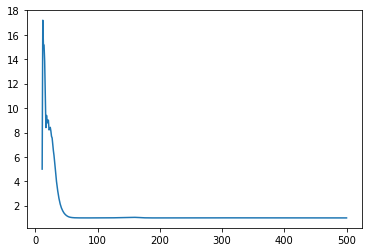

In [48]:
plt.plot(time_series.index, time_series['newly_infected'], label = 'r_0')


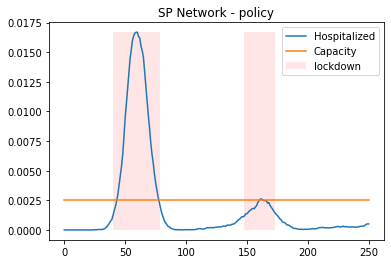

In [29]:
plt.plot(time_series.index, time_series['hospitalized'], label = 'Hospitalized')
plt.plot(time_series.index, len(time_series.index)*[0.0025], label = 'Capacity')
plt.title(f'SP Network - policy')
plt.fill_between(time_series.index[:-1], time_series['hospitalized'].max(), where=np.array(restrictions)[:,1] == 1,
                facecolor='red', alpha=0.1, label='lockdown')
plt.legend()
plt.title(f'SP Network - policy')
plt.savefig(f'Hospital Beds- policy.png', fromat='png', dpi = 300)
plt.show()


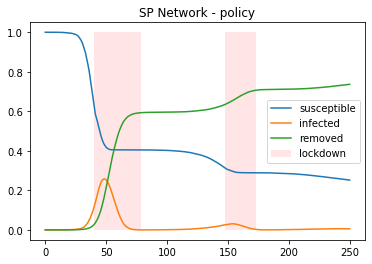

In [30]:
plt.plot(time_series.index, time_series['susceptible'], label = 'susceptible')
plt.plot(time_series.index, time_series['infected'], label = 'infected')
plt.plot(time_series.index, time_series['removed'], label = 'removed')
plt.fill_between(time_series.index[:-1], 0, 1, where=np.array(restrictions)[:,1] == 1,
                facecolor='red', alpha=0.1, label='lockdown')
plt.legend()
plt.title(f'SP Network - policy')
plt.savefig(f'SP network Simulation- policy.png', fromat='png', dpi = 300)
plt.show()


In [80]:
import seaborn as sns
nx.draw(subgraph_of_zone(G, 20, 'home'), node_size=10, pos=nx.spring_layout(G))

KeyboardInterrupt: 

In [77]:
import networkx as nx
import plotly.graph_objects as go

def plot_graph(G):

    #pos = nx.spectral_layout(G)
    pos = nx.spring_layout(G)

    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))


    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),))
    fig.show()


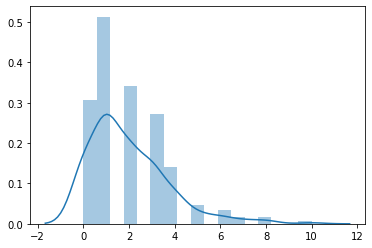

In [65]:
sns.distplot([y for x,y in subgraph_of_zone(G, 75, 'home').degree()])